# *Transformer-Based Topic Modeling for Urdu Translations of the Holy Quran *


# Experimentation
Topic modeling enables the discovery of concealed themes and paterns in extensive text collections. It facilitates athorough
examination of the messages present in religious texts. Topic modeling for uranic verses is a trending study area, with
various translations already explored including Bahasa, English, and Arabic. Yet, there is a need for further research, particularly in Urdu translations of the uran. In this study, we propose applying the BERTopic framework to Urdu translationsof
he Holy uran. By leveraging the BERTopic approach, which incorporates a ine-tuned BERT model, we aim to capture the
contextual nuances and linguistic complexities unique to the uran. In this study, we utilized existing Urdu translations of
the uran from eight diferent translators sourced from Tanzil, a renowned resource for uranic text and translations. We
assessed the performance of our proposed BERTopic model compared to traditional techniques like LDA and NMF, using coherence and diversity metrics. he results indicate that our BERT-based approach outperforms these conventional methods,
achieving an average coherence improvement of 0.03 and a diversity score of 0.83. hese indings highlight the efectiveness
of BERTopic in extracting meaningful topics from Urdu translations of he Holy uran and contribute to the computational
analysis of religious texts, supporting scholarly endeavours in comparative studies of uranic translations in Urdu.

**NOTE**: Make sure to select a GPU runtime. Otherwise, the model can take quite some time to create the document embeddings!

In [ ]:
!pip install urduhack
print("printed")

printed


In [ ]:
import pandas as pd
from gensim.models.coherencemodel import CoherenceModel
import gensim.corpora as corpora
from gensim.models import LdaMulticore
from sklearn.feature_extraction.text import TfidfVectorizer
from urduhack.normalization import remove_diacritics
from sklearn.decomposition import NMF
print("done")


done


In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Data

In [ ]:
junapd = pd.read_table("/content/drive/MyDrive/Quranic-Urdu-Translation/Quran-Urdu_Translation_Dataset/ur.maududi.txt", header=None, encoding='utf-8')

print(junapd.head(5))


stopspd=pd.read_csv('/content/drive/MyDrive/stopwords.txt',names=['List'])

stopspd

                                                   0
0              1|1|اللہ کے نام سے جو رحمان و رحیم ہے
1  1|2|تعریف اللہ ہی کے لیے ہے جو تمام کائنات کا ...
2                              1|3|رحمان اور رحیم ہے
3                             1|4|روز جزا کا مالک ہے
4  1|5|ہم تیری ہی عبادت کرتے ہیں اور تجھی سے مدد ...


,List
0,کی
1,ہیں
2,ہے
3,رہا
4,رہی
...,...
396,گئی
397,ہونے
398,وجہ
399,ہوگیا


In [ ]:
import re
#Remove Urdu Punctuation
def remove_urdu_punctuation(text):
    pattern = r'[؛؟؟،٫٬‘’“”«»!"٪&\'\*\+,-./:;<=>؟@^_`()[]{|}~]'

    cleaned_text = re.sub(pattern, '', text)

    return cleaned_text


In [ ]:
# Remove trailing metadata lines
index_to_drop = junapd[junapd[0].str.startswith("#")].index
junapd.drop(index_to_drop, inplace=True)

# Remove verse reference from every line
junapd[0] = junapd[0].str.replace(r'\d+\|\d+\|', '', regex=True)

# Remove diacritics
junapd[0] = junapd[0].apply(remove_diacritics)

# Remove punctuation
junapd[0] = junapd[0].apply(remove_urdu_punctuation)

# Reset index
junapd.reset_index(drop=True, inplace=True)

# Display the cleaned DataFrame
print("Cleaned DataFrame:")
print(junapd.head())



Cleaned DataFrame:
                                                   0
0                  اللہ کے نام سے جو رحمان و رحیم ہے
1    تعریف اللہ ہی کے لیے ہے جو تمام کائنات کا رب ہے
2                                  رحمان اور رحیم ہے
3                                 روز جزا کا مالک ہے
4  ہم تیری ہی عبادت کرتے ہیں اور تجھی سے مدد مانگ...


In [ ]:
def remove_nonbreaking_space(text):
    return re.sub(r'\xa0', ' ', text)

junapd[0] = junapd[0].apply(remove_nonbreaking_space)

In [ ]:
# Convert the DataFrame to a list of strings
data = junapd[0].tolist()

In [ ]:
stop_words_list = stopspd['List'].tolist()

# LDA

We use the [ parallelized Latent Dirichlet Allocation (LDA)](https://radimrehurek.com/gensim/models/ldamulticore.html) from Gensim.

Note: for LDA you have to define topics number in advance.

In [ ]:
import itertools
from rbo import rbo
import numpy as np

class InvertedRBO:
    def __init__(self):
        pass

    def irbo(self, topics, topk=10, weight=0.9):
        """
        Calculate inverted Rank Biased Overlap (RBO) as a measure of topic diversity from a list of lists of words.

        :param topics: A list of lists of words representing different topics.
        :param topk: The number of top words on which RBO will be computed.
        :param weight: Weight of each agreement at depth d: p**(d-1). When set to 1.0, there is no weight,
                       and the RBO returns to average overlap.
        :return: The inverted RBO topic diversity score.
        """
        if topk <= 0:
            raise ValueError("topk must be a positive integer.")

        num_topics = len(topics)
        if num_topics == 0:
            raise ValueError("topics list cannot be empty.")

        if topk > len(topics[0]):
            raise Exception('Words in topics are less than topk')

        collect = []
        for list1, list2 in itertools.combinations(topics, 2):
            rbo_val = rbo(list1[:topk], list2[:topk], p=weight)[2]
            collect.append(rbo_val)

        Irbo_score = 1 - np.mean(collect)
        return Irbo_score

In [ ]:
# texts = [[word for word in str(document).split()] for document in documents]
texts = [[word for word in str(document).split() if word not in stop_words_list] for document in data]
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]

In [ ]:
# List of different number of topics
num_topics_list = [5, 10, 15, 20, 25,30,35,40,45,50]

# Create a list to store the data for each combination
data_list = []

# Iterate over the different number of topics
for num_topics in num_topics_list:
    # Run LDA for fine tune
    lda = LdaMulticore(corpus, id2word=id2word, num_topics=num_topics, random_state=42)

    topics = lda.show_topics(num_words= 10, num_topics=num_topics,  formatted=False)

    # Extract the words from the topics
    topics_list = []
    for _, topic_words in topics:
        words = [word for word, _ in topic_words]
        # Clean words if necessary
        #words = [word.strip("'[]") for word in words]
        topics_list.append(words)

    print(topics_list)

    # Calculate coherence scores using Gensim's Coherence Model
    coherence_cv = CoherenceModel(topics=topics_list, texts=texts, dictionary=id2word, coherence='c_v')
    cv_score = round(coherence_cv.get_coherence(),2)
    coherence_npmi = CoherenceModel(topics=topics_list, texts=texts, dictionary=id2word, coherence='c_npmi')
    npmi_score = round(coherence_npmi.get_coherence(),2)

    # Calculate Unique Word count
    unique_words = round(proportion_unique_words(topics_list, topk=10),2)

    # Calculate IRBO Score
    inverted_rbo_calculator = InvertedRBO()
    IRBO = round(inverted_rbo_calculator.irbo(topics_list, topk=10, weight=0.9),2)

    # Append the data for the current combination to the list
    data_list.append({
        'Model': 'LDA',
        'n_Topics': num_topics,
        'C_v score': cv_score,
        'C_NPMI score': npmi_score,
        'Unique Word': unique_words,
        'IRBO': IRBO,
        'Topics': topics_list})

# Create a DataFrame from the data list
df1 = pd.DataFrame(data_list)

# Print the DataFrame
print(df1)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[['اللہ', 'رب', 'تمہارے', 'ہے،', 'تمہیں', 'و', 'نہیں،', 'لوگوں', 'ساتھ', 'لوگ'], ['عبادت', 'رب', 'ہے،', 'کوئی', 'اللہ', 'والا', 'مال', 'لوگوں', 'و', 'روز'], ['اللہ', 'کوئی', 'لوگ', 'لوگوں', 'والا', 'ہے،', 'عذاب', 'رب', 'ہیں،', 'شخص'], ['رب', 'اللہ', 'لوگ', 'قسم', 'تمہارے', 'دن', 'ساتھ', 'تمہارا', 'حال', 'ایمان'], ['اللہ', 'رب', 'لوگوں', 'لوگ', 'کوئی', 'ساتھ', 'تمہارے', 'ایمان', 'بات', 'چیز']]


[['اللہ', 'تمہارے', 'یتیم', 'رب', 'ساتھ', 'و', 'تمہیں', 'زمین', 'لوگوں', 'ہے،'], ['مال', 'اللہ', 'روز', 'بازو', 'کوئی', 'نفس', 'رب', 'لوگوں', 'پلڑے', 'تلقین'], ['اللہ', 'کوئی', 'لوگوں', 'لوگ', 'والا', 'دن', 'تمہیں', 'ہیں،', 'ایمان', 'عذاب'], ['اللہ', 'رب', 'قسم', 'لوگ', 'لوگوں', 'شر', 'رات', 'ساتھ', 'ایمان', 'دوسرے'], ['اللہ', 'عبادت', 'ساتھ', 'لوگ', 'ہرگز', 'لوگوں', 'رب', 'کوئی', 'دیکھ', 'لو'], ['ہے،', 'کوئی', 'رب', 'اولاد', 'قسم', 'عظیم', 'ہے؟', 'لوگوں', 'شخص', 'قدر'], ['اللہ', 'لوگ', 'رب', 'لوگوں', 'بات', 'تمہارے', 'اے', 'دو', 'انسان', 'روز'], ['اللہ', 'رب', 'تمہیں', 'ہے،', 'چیز', 'تمہارا', 'لوگوں', 'کوئی', 'و', 'جائیں'], ['اللہ', 'انسان', 'لوگ', 'عبادت', 'عذاب', 'رب', 'کوئی', 'سرکشی', 'ہے،', 'تمہارے'], ['رب', 'اللہ', 'تمہارے', 'کوئی', 'والا', 'ہرگز', 'نہیں،', 'ہے،', 'لوگ', 'یقینا']]


[['اللہ', 'تمہیں', 'و', 'کھانا', 'مسکین', 'رب', 'تمہارے', 'ہے،', 'اے', 'لوگوں'], ['عبادت', 'مال', 'کوئی', 'اولاد', 'عظیم', 'تلقین', 'والا', 'سے)', 'روز', 'خوش'], ['اللہ', 'لوگ', 'کوئی', 'لوگوں', 'والا', 'ایمان', 'دن', 'دنیا', 'نہیں،', 'شخص'], ['رب', 'اللہ', 'لوگ', 'ساتھ', 'میرے', 'انسان', '(اپنے', 'آزمائش', 'عزت', 'کہتا'], ['اللہ', 'شر', 'ساتھ', 'رب', 'لوگ', 'شک', 'لوگوں', 'درست', 'اے', 'والوں'], ['رب', 'ہے،', 'شخص', 'ڈالتا', 'ہے؟', 'لوگوں', 'و', 'چور', 'دیکھا', 'کوئی'], ['اللہ', 'لوگ', 'یتیم', '(اے', 'رب', 'لوگوں', 'تمہیں', 'تمہارے', 'ایمان', 'پس'], ['اللہ', 'رب', 'تمہارا', 'و', 'ہمیشہ', 'کوئی', 'ہے،', 'تمہیں', 'حال', 'لوگوں'], ['انسان', 'تمہارے', 'اللہ', 'دین', 'لوگ', 'والوں', 'رب', 'کیا؟', 'ایمان', 'دو'], ['اللہ', 'رب', 'کوئی', 'تمہارے', 'ہرگز', 'ہے،', 'لوگ', 'نہیں،', 'یقینا', 'والا'], ['اللہ', 'لوگوں', 'عذاب', 'تمہارے', 'لو', 'زمین', 'دیکھ', 'کوئی', 'رب', 'پاس'], ['اللہ', 'تمہارے', 'لوگوں', 'زمین', 'لوگ', 'و', 'کوئی', 'مال', 'پیدا', 'تمہیں'], ['انسان', 'چیز', 'اللہ', 'رب', 'جانتا',

[['اللہ', 'بے', 'تمہیں', 'رب', 'پیدا', 'نیاز', 'دوسرے', 'و', 'ساتھ', 'تمہارے'], ['ہمیشہ', 'انسان', 'اللہ', 'نہیں،', 'روز', 'کوئی', 'لوگوں', 'ہرگز', 'گے،', 'ذات'], ['اللہ', 'لوگوں', 'لوگ', 'کوئی', 'شخص', 'ہے؟', 'دیکھا', 'ہیں،', 'مارتے', 'دنیا'], ['شر', 'رب', '(اپنے', 'حال', 'پیدا', 'اللہ', '(اے', 'نہیں،', 'پے', 'شہر'], ['اللہ', 'ساتھ', 'تلقین', 'پس', 'روز', 'رب', 'لوگوں', 'لوگ', 'بار', 'حقیقت'], ['اولاد', 'کوئی', 'چور', 'ہے،', 'رب', 'لوگوں', 'پاس', 'نازل', 'جانو', 'اللہ'], ['اللہ', 'لوگ', 'رب', '(اے', 'تمہیں', 'بری', 'و', 'لوگوں', 'مال', 'فوج'], ['اللہ', 'تمہارا', 'رب', 'تمہیں', 'کوئی', 'و', 'چیز', 'والا', 'منہ', 'بازو'], ['انسان', 'رب', 'خاطر', 'اللہ', 'ہے،', 'دیتا', 'بے', 'بڑا', 'راستہ', 'لوگ'], ['رب', 'اللہ', 'تمہارے', 'ہے،', 'کوئی', 'خوب', 'یقینا', 'میرے', 'تمہارا', 'انسانوں'], ['زمین', 'رب', 'اللہ', 'تمہارے', 'قدر', 'شب', 'عذاب', 'قسم', 'ذات', 'لوگوں'], ['اللہ', 'یتیم', 'لوگ', 'دنیا', 'کوئی', 'اندر', 'اے', 'لوگوں', 'ملکوں', 'زمین'], ['عبادت', 'عظیم', 'دن', 'رات', 'اللہ', 'مشقت', 'ل

[['اللہ', 'تمہیں', 'گزار', 'ہوگی', 'لوگ', 'یقینا', 'و', 'رب', 'ہدایت', 'تمہارے'], ['رب', 'بڑا', 'آیات', 'انسان', 'حقیقت', 'داخل', 'ہماری', 'جنت', 'کوئی', 'لوگ'], ['اللہ', 'کوئی', 'لوگ', 'لوگوں', 'راہ', 'تمہارا', 'رب', 'تمہیں', 'سوا', 'ساتھ'], ['رب', '(اپنے', 'اللہ', 'تمہارے', 'سے)', 'محبت', 'لوگ', 'حال', 'بے', 'انسانوں'], ['روز', 'شر', 'اللہ', 'لوگ', 'لوگوں', 'قسم', 'دو', 'رب', 'جہنم', 'وقت'], ['شخص', 'قسم', 'پیدا', 'ڈالتا', 'ہے،', 'لوگوں', 'چور', 'رب', 'تمہاری', 'چیز'], ['اللہ', 'لوگ', 'یتیم', 'رب', 'فوج', 'گن', 'کوئی', 'دیکھ', 'ایمان', 'لوگوں'], ['اللہ', '(اے', 'رب', 'تمہیں', 'والا', 'یقینا', 'بد', 'جائیں', 'لوگوں', 'و'], ['قسم', 'لوگ', 'ملکوں', 'رب', 'دنیا', 'بڑی', 'پس', 'لیں', 'مشرکین', 'بلا'], ['رب', 'اللہ', 'کوئی', 'تمہارے', 'تیرے', 'تمہارا', 'ہے،', 'لوگ', 'دین', 'زمین'], ['عذاب', 'اللہ', 'کوئی', 'دور', 'پہلے', 'والا', 'قدر', 'شب', 'ویسا', 'بہتر'], ['اللہ', 'کوئی', 'و', 'لوگ', 'تمہارے', 'لوگوں', 'رب', 'پیدا', 'مال', 'قسم'], ['رات', 'دن', 'چیز', 'ساتھ', 'رب', 'تمہارے', 'اللہ', 'تم

[['یتیم', 'اللہ', 'ہوگی', 'و', 'دو', 'قسم', 'نہیں،', 'میرے', 'ہے،', 'وہی'], ['روز', 'انسان', 'بارے', 'دو', 'کار', 'سخت', 'آفت', 'ضرور', 'صبح', 'بلا'], ['اللہ', 'لوگ', 'کوئی', 'دن', 'مال', 'گردن', 'لوگوں', 'عذاب', 'رب', 'ہیں،'], ['مسکین', 'کھانا', 'لوگ', 'بہترین', '(اپنے', 'حال', 'نیک', 'اللہ', 'سے)', 'ایمان'], ['رب', 'جانو', 'اللہ', 'ساتھ', 'خوب', 'حقیقت', 'تنگی', 'روز', 'لوگوں', 'بے'], ['چور', 'ہے،', 'تمہاری', 'پیدا', 'پہلے', 'ذکر', 'تمہارے', 'لوگ', 'قسم', 'رب'], ['رب', 'اللہ', 'لوگ', 'شخص', 'فوج', 'سہولت', 'تمہارا', 'حق', 'لو', 'دیکھ'], ['رب', 'اللہ', 'تمہیں', 'بچا', 'نمایاں', 'فراخی', 'چیز', 'و', 'کو)', 'کوئی'], ['رب', 'عذاب', 'تمہارے', 'اللہ', 'آخرکار', 'مٹی', 'قربانی', 'گزار', 'اندر', 'قابو'], ['رب', 'اللہ', 'تمہارا', 'یقینا', 'ہے،', 'ہرگز', 'لوگ', 'تمہارے', 'نہیں،', 'کوئی'], ['عذاب', 'کوئی', 'اللہ', 'قوم', 'دن', 'پاس', 'والا', 'لوگ', 'بدلہ', 'بھیج'], ['اللہ', 'قسم', 'تمہیں', 'عبادت', 'ملکوں', 'لوگ', 'دنیا', 'کوئی', 'رب', 'تمہارے'], ['انسان', 'غفلت', 'لوگوں', 'اللہ', 'علم', 'جانتا

[['یتیم', 'قسم', 'دیتا', 'پیدا', 'سہولت', 'کھانا', 'راستے', 'چھا', 'مسکین', 'اللہ'], ['تمہیں', 'ماننے', 'ہے،', 'برپا', 'بلا', 'حالت', 'بخشی', 'انکار', 'فساد', 'سلوک'], ['اللہ', 'لوگوں', 'کوئی', 'لوگ', 'دن', 'بے', 'ساتھ', 'باز', 'آگ', 'کو)'], ['ساتھ', 'رب', '(اپنے', 'بے', 'فراخی', 'سے)', 'شخص', 'شک', 'اللہ', 'ہے؟'], ['عمل', 'لوگ', 'نیک', 'اللہ', 'خوف', 'رب', 'راضی', 'ایمان', 'روز', 'روشن'], ['قسم', 'ڈالتا', 'اے', 'ہے،', 'رب', 'ذریعہ', 'دو', 'قلم', 'دھوپ', 'دھکے'], ['اللہ', 'لوگ', 'کو)', 'دیکھ', 'فوج', 'دن', 'جانتا', 'رب', 'لوگوں', 'ہے؟'], ['اللہ', 'رب', 'تمہیں', 'و', 'آگ', 'پس', 'مشرکین', 'جائیں', 'کتاب', 'عنقریب'], ['رب', 'تمہارا', 'بے', 'راستہ', 'کے)', 'معلوم', 'جانوروں', 'سے)', 'شک', 'بتانا'], ['رب', 'اللہ', 'تمہارے', 'تمہارا', 'یقینا', 'ہے،', 'خوب', 'لوگ', 'ہرگز', 'والا'], ['دور', 'بچا', 'تمہارے', 'پہلے', 'جائیں', 'لوگ', 'اللہ', 'دن', 'عنقریب', 'عذاب'], ['اللہ', 'تمہیں', 'مال', 'میں)', 'پرہیز', 'آخر', 'لوگوں', 'قسم', 'ڈھانک', 'ہلاک'], ['اللہ', 'عظیم', 'انسانوں', 'نماز', 'لوگ', 'دن',

[['نہیں،', 'ہرگز', 'اللہ', 'جھٹلایا', '(اے', 'یتیم', 'و', 'شخص', 'کوئی', 'ہے،'], ['بھڑکتی', 'آگ', 'گزرے', 'کار', 'پس', 'اتنا', '(راہ', 'دنیا،', 'منع', 'کمر'], ['اللہ', 'گردن', 'کوئی', 'لوگ', 'لوگوں', 'رب', 'مال', 'تباہی', 'فرشتے', 'ہیں،'], ['رب', '(اپنے', 'حال', 'ساتھ', 'آزمائش', 'عزت', 'دیا؟', 'بازو', 'اونٹنی', 'اللہ'], ['رب', 'ساتھ', 'راضی', 'مال', 'سمجھتا', 'شک', 'بے', 'اللہ', 'ہمیشہ', 'گی،'], ['رب', 'ہے،', 'پہاڑ', 'ہو؟', 'بدی', 'ذریعہ', 'اظہار', 'نعمت', 'منع', 'قلم'], ['لوگ', 'قسم', 'اللہ', 'اٹھا', 'قوم', 'ثمود', 'آدمی', 'رب', 'کو)', 'بات'], ['اللہ', 'رب', 'عنقریب', '(اے', 'لوگ', 'کوئی', 'ہرگز', 'معلوم', 'تمہیں', 'لوگوں'], ['محبت', 'نمایاں', 'کیا؟', 'رب', 'والوں', 'اللہ', 'تمہارے', 'ساتھ', 'دیتا', 'فرعون'], ['رب', 'اللہ', 'تمہارے', 'یقینا', 'پے', 'انسانوں', 'کوئی', 'ہے،', 'لوگ', '(اے'], ['عذاب', 'اللہ', 'گزار', 'حالت', 'لوگ', 'جائیں', '(اس', 'حقیقت', 'جانتا', 'نکال'], ['قسم', 'اللہ', 'یتیم', 'نیاز', 'ذات', 'بے', 'و', 'زمین', 'دو', 'آسمان'], ['عبادت', 'رات', 'انسان', 'دن', 'ڈھانک', 

[['بھڑکتی', 'اللہ', 'تمہارے', 'آگ', 'ساتھ', 'تمہیں', 'سوائے', 'پھیر', 'یقین', 'الٹا'], ['شر', 'حالت', 'بازو', 'پیدا', 'روز', 'رب', 'ذات', 'یقینا', 'لوگ', 'آیات'], ['اللہ', 'لوگ', 'کوئی', 'دیا؟', 'تمہیں', 'لوگوں', 'راہ', 'خوب', 'بے', 'گھر'], ['کھانا', 'چھا', 'رات', 'اللہ', 'ٹھکانا', 'قسم', 'دوسرے', 'لوگ', 'وہی', 'دن'], ['عبادت', 'اللہ', '(اس', 'اٹھا', 'ساتھ)', 'قوم', 'رب', 'لوگوں', 'لوگ', 'ساتھ'], ['کیا؟', 'لو', 'شخص', 'ہے،', 'معبود', 'رب', 'حقیقی', 'پہاڑ', 'انسانوں', 'پرہیزگاری'], ['رب', 'اللہ', 'سے)', 'لوگ', 'روشن', '(اپنے', 'آ', 'دن', 'راضی', 'خدا'], ['(اے', 'تمہارا', 'رب', 'اللہ', 'عظیم', 'ہرگز', 'تمہیں', 'یقینا', 'جاؤ', 'پا'], ['دو', 'اے', 'ثمود', 'دل', 'ساتھ', 'پسند', 'بدی', 'عیش', 'بتانا', 'عظیم'], ['اللہ', 'تمہارے', 'دین', 'رب', 'تمہارا', 'میرا', 'ہے،', 'میرے', 'کوئی', 'گزرے'], ['اللہ', 'جانتا', 'کہتا', 'رب', 'والوں', 'زمین', 'بے', 'ہے؟', 'پے', 'میری'], ['جانو', 'اللہ', 'میں)', 'ہے؟', 'سے)', 'پہنچ', 'علم', 'تنگ', 'ذریعہ', '(اسی'], ['دن', 'اللہ', 'لوگ', 'لوگوں', 'نماز', 'فکر', '(

[['اللہ', 'پیدا', 'تمہارا', 'سہولت', 'ہاتھ', 'قرار', 'راہ', 'شہر', 'ہوگی', 'راست'], ['بری', 'کوئی', 'روز', 'بدلہ', 'بارے', 'احسان', 'دیکھا', 'ساتھ', 'لوگوں', 'رب'], ['اللہ', 'ہوگی', 'لوگوں', 'کوئی', 'خوب', 'دو', 'لوگ', 'دور', 'نیکی', 'دیکھ'], ['(اس', 'سے)', 'کوئی', 'لوگ', 'ضرور', 'مانا', 'ا', 'س', 'اللہ', '(اپنے'], ['روز', 'عبادت', 'گن', 'رب', 'مال', 'اللہ', 'خوب', 'سچ', 'قسم', 'جواب'], ['ذریعہ', 'کہتا', 'فرشتے', 'پرہیزگاری', 'ہو؟', 'مہینوں', 'تفرقہ', 'چور', 'ڈالی', 'ساتھ)'], ['شر', 'اللہ', 'لوگ', 'لوگوں', 'ایمان', 'تمہارے', 'ذکر', 'عمل', 'تمہاری', 'نہیں،'], ['رب', 'راستے', 'پے', 'تمہارا', 'اللہ', 'زمین', 'در', 'حقیقت', 'بڑا', 'جنتیں'], ['تمہیں', 'دن', 'نفس', 'پس', 'ذات', 'دو', 'فرعون', 'پکی', 'مٹی', 'قربانی'], ['اللہ', 'رب', 'تمہارے', 'ہے،', 'لوگ', 'والا', 'کوئی', 'مال', 'حال', 'بھیج'], ['سرکشی', 'ہے؟', 'ہرگز', 'اللہ', 'بے', 'و', 'نیاز', 'جانو', 'کہ)', 'عنقریب'], ['انسان', 'انسانوں', 'اللہ', 'رب', 'حقیقت', 'راستہ', 'تمہارا', 'بڑا', 'در', 'دشمن'], ['دن', 'جانو', 'بچا', 'لوگوں', 'لوگ', 

In [ ]:
df1.to_csv('LDA.csv', mode='a', index=False,  encoding='utf-8-sig')

In [ ]:
import matplotlib.pyplot as plt

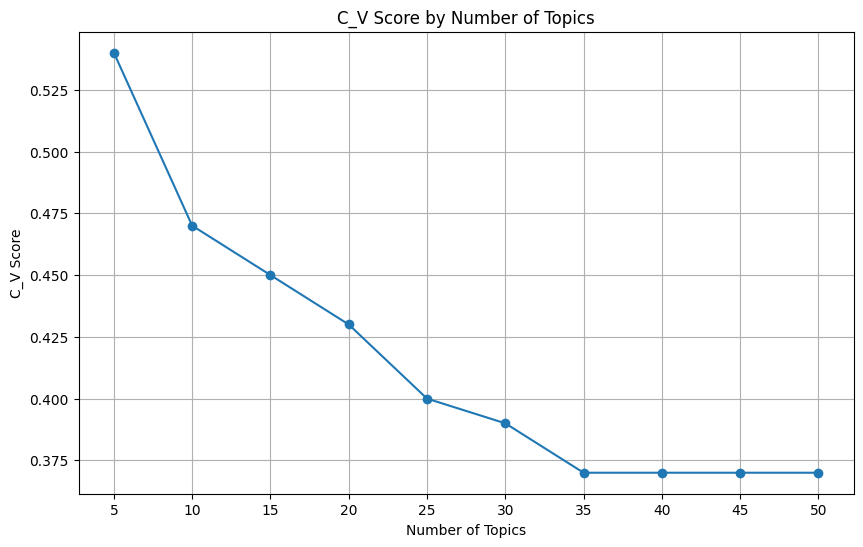

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df1['n_Topics'], df1['C_v score'], marker='o')
plt.title('C_V Score by Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('C_V Score')
plt.grid(True)
plt.xticks(df1['n_Topics'])  # Ensures all x-axis labels are shown
plt.savefig('C_V_scores_plot.png')  # Save the plot as an image file
plt.show()  # Display the plot